In [1]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.6/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.6/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 185 (delta 5), reused 0 (delta 0), pack-reused 171
Receiving objects: 100% (185/185), 57.14 KiB | 232.00 KiB/s, done.
Resolving deltas: 100% (67/67), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT CHANGES: RAPIDS on Colab will be pegged to 0.14 Stable until further notice.
2. Default stable version is now 0.14.  Nightly will redirect to 0.14.
3. You can now declare your RAPIDSAI version as a CLI option and skip the user prompts (ex: '0.14' or '0.15', between 0.13 to 0.14, without the quotes): 
        "!bash rapidsai-csp-utils/colab/rapids-colab.sh <version/label>"
        Examples: '!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.14', or '!bash rapidsai-csp-utils/colab/rapids-colab.sh stable', or '!bash ra

In [2]:
import cuml


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import time
import sys, gc
import seaborn as sns
import random
from itertools import chain
from tqdm.notebook import tqdm
import math
import scipy as si
from scipy.stats import norm

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples

import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as tf1
from sklearn.preprocessing import PolynomialFeatures
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import torch 
from torch import matmul
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import torch.distributions as tdist

#from kmeans_pytorch import kmeans

print('GPU available: ',torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

GPU available:  True


In [5]:
### Model parameters
dim_X = 40

N_sim = 50000

eps = 0.025
max_epochs = 300

# 1 Data simulator

In [6]:
class var_es_generator:
    """ 
    Data generator for VaR and ES Case study

    var_es_generator simulates a matrix of input X, an output vector Y
    and true conditional VaR and ES for benchmark.  

    Parameters
    ----------
    dim_X : int, default= Model parameters
        Dimension of input features.
    eps : float, default= Model parameters
        1 - eps is the involved confidence level. 0 < eps < 1.
    lambda_0 : float, default= 0
        Intercept in the polynomial function of conditional mean.
    mu_0 : float, default= 0
        Intercept in the polynomial function of conditional standard deviation.    
    lambda_rs : int, default= None
        Determines random number generation for lambda coefficients.    
    mu_rs : int, default= None
        Determines random number generation for mu coefficients.     
    Attributes
    ----------
    dim_X : int
    eps : float
    lambda_vector : array
        Vector of lambda coefficient drawn independently from U[0,1]
    mu_vector : array
        Vector of lambda coefficient drawn independently from U[0,1]
    Notes
    ----------
    Data is sumulated on CPU.    
    """
    def __init__(self, dim_X = dim_X, eps = eps, lambda_0 = 0., mu_0 = 0.,
                 lambda_rs = None, mu_rs = None):
        self.dim_X = dim_X
        self.eps = eps
        
        self.lambda_vector = np.append(lambda_0, np.random.RandomState(lambda_rs).uniform(0,1, int(dim_X + dim_X*(dim_X+1)/2) ))
        self.mu_vector = np.append(mu_0, np.random.RandomState(mu_rs).uniform(0,1, int(dim_X + dim_X*(dim_X+1)/2) ))
    
    def mean_X(self):
        """
        Generate mean vector of X

        Returns
        -------
        Mean vector 
        """
        return np.zeros(self.dim_X)
    
    def var_X(self, correlation = False):
        """
        Generate covariance matrix of X

        Parameters
        ----------
        correlation : bool, default= False
            If True, return a full symmetric (dim_X, dim_X) covariance matrix,
            else return an identity matrix.
        Returns
        -------
        Covariance matrix 
        """
        
        if correlation == False:
            return np.identity(self.dim_X)
        else:
            A = np.random.randn(self.dim_X,self.dim_X)
            A = np.matmul(A.T,A)
            A /= A.max()
            np.fill_diagonal(A,1)
            return A

    def poly_function(self, X, coefficient_vector): 
        """
        Compute a multivariate polynomial function of degree 2 from a input and
        coefficient vector.

        Parameters
        ----------
        X : array
            A input vector.
        coefficient_vector: array
            A coefficient vector.
        Returns
        -------
        A real-value of polynomial of degree 2.
        """
        poly = PolynomialFeatures(2)
        return np.sum(poly.fit_transform(X) * coefficient_vector, axis = 1)
    
    def simulate(self, N_sim = N_sim) :

        """
        Simulate data and wrap to torch.Tensor.
        Parameters
        ----------
        N_sim : int, default= Model parameters
            Number of observations to simulate.
        Returns
        -------
        X : torch.Tensor, shape (N_sim, dim_X)
            Matrix of input
        Y : torch.Tensor, shape (N_sim, 1) 
            Vector of output
        true_var : torch.Tensor, shape (N_sim, 1)
            Vector of true conditional VaR for benchmark. 
        true_es : torch.Tensor, shape (N_sim, 1)
            Vector of true conditional ES for benchmark. 
        mean_Y : torch.Tensor, shape (N_sim, 1)
            Vector of true mean of Y. 
        std_Y : torch.Tensor, shape (N_sim, 1)
            Vector of true standard deviation of Y. 
        """                
        X = np.random.multivariate_normal(self.mean_X(), self.var_X(), N_sim)

        mean_Y = self.poly_function(X, self.lambda_vector)
        std_Y = self.poly_function(X, self.mu_vector)
        std_Y = np.sqrt(std_Y**2)
        
        Y = np.random.normal(mean_Y, std_Y)

        true_VaR = mean_Y - std_Y*norm.ppf(self.eps)
        true_ES = mean_Y + 1/self.eps * std_Y * norm.pdf(norm.ppf(self.eps)) 

        return (torch.from_numpy(X.reshape(N_sim, self.dim_X)).type(torch.FloatTensor), 
                torch.from_numpy(Y.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_VaR.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_ES.reshape(-1,1)).type(torch.FloatTensor),
                mean_Y,
                std_Y)

In [7]:
sys_variables = sys.modules[__name__]

def data_simulator(nb_path = N_sim):
    try:
        del sys_variables.X_train, sys_variables.Y_train, sys_variables.true_VaR_train, sys_variables.true_ES_train
        del sys_variables.X_test, sys_variables.Y_test, sys_variables.true_VaR_test, sys_variables.true_ES_test
        torch.cuda.empty_cache()
    except:
        pass
    
    X_train, Y_train, true_VaR_train, true_ES_train, mean_Y_train, std_Y_train = Data_Generator.simulate(nb_path)
    X_test, Y_test, true_VaR_test, true_ES_test, mean_Y_test, std_Y_test = Data_Generator.simulate(nb_path)

    sys_variables.X_train = X_train.to(device)
    sys_variables.Y_train = Y_train.to(device)
    sys_variables.true_VaR_train = true_VaR_train.to(device)
    sys_variables.true_ES_train = true_ES_train.to(device)

    sys_variables.X_test = X_test.to(device)
    sys_variables.Y_test = Y_test.to(device)
    sys_variables.true_VaR_test = true_VaR_test.to(device)
    sys_variables.true_ES_test = true_ES_test.to(device)

In [8]:
def NRMSE(pred, true):
    """
    Normalized Root-Mean-Square Error
    
    It is Root-Mean-Square Error normalized by the standard error of true target.

    Parameters
    ----------
    pred : torch.Tensor
    true : torch.Tensor
    Returns
    -------
    NRMSE. 
    """
    pred = pred.cpu().reshape(true.shape)
    true = true.cpu()
    return float(torch.sqrt(torch.mean((pred - true)**2))/ torch.std(true))

def RMSE(pred, true):
    """
    Root-Mean-Square Error
    
    It is Root-Mean-Square Error between the prediction and true target.

    Parameters
    ----------
    pred : torch.Tensor
    true : torch.Tensor
    Returns
    -------
    RMSE. 
    """
    pred = pred.cpu().reshape(true.shape)
    true = true.cpu()
    return float(torch.sqrt(torch.mean((pred - true)**2)))

def qloss(pred, y):
    """
    Quantile loss
    
    This function computes quantile (pinball) loss.

    Parameters
    ----------
    pred : torch.Tensor
    y : torch.Tensor
    Returns
    -------
    NRMSE. 
    """
    u = y.reshape(pred.shape).cpu() - pred.cpu()
    return float(torch.mean((u)*(1- eps - (u<0)*1)))

def q_proba(pred, y):
    """
    Quantile probability
    
    This function computes probability that the target exceed the prediction.

    Parameters
    ----------
    pred : torch.Tensor
    y : torch.Tensor
    Returns
    -------
    NRMSE. 
    """
    pred = pred.cpu().reshape(y.shape)
    y = y.cpu()
    return float(sum(y >pred))/len(y)

def huber_loss(pred, y, tau, eps = eps):
    """
    Huber loss
    
    This function computes Huber loss which allows to train quantile model.

    Parameters
    ----------
    pred : torch.Tensor
    y : torch.Tensor
    tau : float
        Huber switching threshold.
    eps : float, default = Model parameters
    Returns
    -------
    Huber loss. 
    """
    zero_vector = torch.zeros_like(y)
    u = y - pred
    hu = u**2/(2*tau)*(torch.abs(u)<=tau) + (torch.abs(u) - tau/2)*(torch.abs(u)>tau)
    loss_var = torch.mean((1-eps)*hu*(u>=zero_vector) + eps*hu*(u<zero_vector))
    return loss_var

def plot_function(var_train_pre, var_train_true, es_train_pre, es_train_true,
                  var_test_pre, var_test_true, es_test_pre, es_test_true):
    """
    Plot function
    
    This function print all comparison metrics and density plot of predicted and 
    true VaR and ES.

    Parameters
    ----------
    var_train_pre : torch.Tensor 
    var_train_true : torch.Tensor
    es_train_pre : torch.Tensor
    es_train_true : torch.Tensor
    var_test_pre : torch.Tensor
    var_test_true : torch.Tensor
    es_test_pre : torch.Tensor
    es_test_true : torch.Tensor
    Returns
    -------
    Print and plot results. 
    """

    [var_train_pre, var_train_true, es_train_pre, es_train_true,
     var_test_pre, var_test_true, es_test_pre, es_test_true]= \
     [var.cpu() for var in [var_train_pre, var_train_true, es_train_pre, es_train_true,
                            var_test_pre, var_test_true, es_test_pre, es_test_true]]

    plt.figure(figsize=(14,7))
    plt.subplot(221)
    g = sns.distplot(var_test_pre.cpu().data, label='predicted VaR')
    g = sns.distplot(var_test_true.data, label='True VaR')
    g = plt.title("out-of-sample VaR distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=10)
    g = plt.legend()

    plt.subplot(222)
    g = sns.distplot(es_test_pre.data, label='predicted ES')
    g = sns.distplot(es_test_true.data, label='True ES')
    g = plt.title("out-of-sample ES distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=10)
    g = plt.legend()

    plt.figure(figsize=(12,10))
    plt.subplot(321)
    d = pd.DataFrame(np.concatenate([(var_train_pre - var_train_true).detach().numpy(),
                                     (var_test_pre - var_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot VaR error", fontsize=12)

    plt.subplot(322)
    d = pd.DataFrame(np.concatenate([(es_train_pre - es_train_true).detach().numpy(),
                                     (es_test_pre - es_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot ES error", fontsize=12)

    print('NRMSE in-sample VaR: ',NRMSE(var_train_pre.data, var_train_true.data))
    
    print('NRMSE out-sample VaR: ',NRMSE(var_test_pre.data, var_test_true.data))
    print('NRMSE in-sample ES: ',NRMSE(es_train_pre.data, es_train_true.data))
    print('NRMSE out-sample ES: ',NRMSE(es_test_pre.data, es_test_true.data))

    print('RMSE in-sample VaR: ',RMSE(var_train_pre.data, var_train_true.data))
    print('RMSE out-sample VaR: ',RMSE(var_test_pre.data, var_test_true.data))

    print('Quantile loss in-sample: ', qloss(var_train_pre.data, Y_train))
    print('Quantile loss out-sample: ', qloss(var_test_pre.data, Y_test))

    print('Quantile proba in-sample: ', q_proba(var_train_pre.data, Y_train))
    print('Quantile proba out-sample: ', q_proba(var_test_pre.data, Y_test))

In [16]:
Data_Generator = var_es_generator()
data_simulator()

#2 Random layers

In [9]:
class Rademacher_dist:
    """ 
    Rademacher distribution

    Rademacher_dist is a generator of Rademacher distribution taking values 
    +1 and −1 with probability 1/2 for each. Rademacher_dist serves to create 
    random projection matrix.
    """
    def sample(dim):
        """
        Simulate data drawn from Rademacher distribution.

        Parameters
        ----------
        dim : list
            Shape of simulated data.
        Returns
        -------
        Generated data whose the shape = dim.
        """
        return 2*tdist.bernoulli.Bernoulli(0.5).sample(dim)-1
        
class Achlioptas_dist:
    """ 
    Achlioptas distribution

    Achlioptas_dist is a generator of Rademacher distribution taking values 
    +√3, 0 and −√3 with probability 1/6, 2/3, 1/6 respectively. Rademacher_dist 
    serves to create random projection matrix.  
    """
    def sample(dim):
        """
        Simulate data drawn from Achlioptas distribution.
        
        Parameters
        ----------
        dim : list
            Shape of simulated data.
        Returns
        -------
        Generated data whose the shape = dim.
        """
        return (tdist.categorical.Categorical(probs=torch.tensor([1/6,2/3,1/6])).sample(dim) -1)*np.sqrt(3)

class Randomprojection:
    """ 
    Random projection mapping

    Randomprojection maps the input data into a new dimentional space, a bias 
    term can be added to transformed data, and then an activation function can 
    be applied. Randomprojection can transform the data several times but it is 
    not necessary.

    Parameters
    ----------
    Layers : list, default= [10,100]
        The first element of this list is the dimension of input, the second 
        element is the dimension of new space. If the length of list d is more
        than two, this means the transformation is applied d-1 times into the 
        corresponding dimension of new spaces. 
    bias : bool, default= True
        Whether to apply the intercept for the transformation.
    activation : function, default= F.relu
        Activation function.
    projection : string, default = 'Gauss'
        The distribution of Random projection: 'Gauss' for Gaussian distribution,
        'Rademacher' for Rademacher distribution and 'Achlioptas' for Achlioptas 
        distribution.        
    random_state : int, default= None
        Determines random number generation for random projection matrix.     
    Attributes
    ----------
    dist : distribution
        Random projection distribution.
    W : list
        List of weights (cf. Random projection matricies). The length of this
        list is equal to the one of Layers minus one.
    b : list
        List of biases. It is empty if bias = False
    activation : function
        Activation function.
    bias : bool
        Whether to apply the intercept for the transformation.
    """
    def __init__(self, Layers = [10, 100], bias = True, activation = F.relu, projection = 'Gauss', random_state = None):
        if projection == 'Gauss':
            dist = tdist.normal.Normal(0., 1.)
        elif projection == 'Rademacher':
            dist = Rademacher_dist
        elif projection == 'Achlioptas':
            dist = Achlioptas_dist

        self.W, self.b =[], []
        if random_state == None:
            for input_size, output_size in zip(Layers, Layers[1:]):
                self.W.append(dist.sample((input_size, output_size)))
                if bias:
                    self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))
        else:
            for i,input_size, output_size in zip(range(len(Layers)-1),Layers, Layers[1:]):
                torch.manual_seed(random_state+i)
                self.W.append(dist.sample((input_size, output_size)))
                if bias:
                    torch.manual_seed(2*random_state+i)
                    self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))

        self.activation = activation
        self.bias = bias
    def fit_transform(self, X):
        """
        Transform input X with specified setup.

        Parameters
        ----------
        X : torch.Tensor, shape = X.shape
            Input data.
        Returns
        -------
        Transformed data whose the shape = (X.shape[0], Layers[-1])
        """
        X = X.to(device)
        if self.bias:
            for W,b in zip(self.W, self.b):
                X = self.activation(torch.matmul(X, W.to(device)) + b.to(device))
        else :
            for W in self.W:
                X = self.activation(torch.matmul(X, W.to(device)))
        return X

#3 Readout layers optimization

In [10]:
class LR_readout_cuml:
    """
    Linear regression (for readout layer) by matrix inversion 

    LR_readout_cuml performs linear regression using the fast GPU matrix 
    inversion in cuml package.

    Parameters
    ----------
    intercept : bool, default = True
        Whether to compute the intercept for this model.
    normalize : bool, default = False
        Whether to normalize the input matrix X.
    regularization_weight : float, defalut = 0 
        Regularization strength. Larger values specify stronger regularization.
    Attributes
    ----------
    lin_reg : Linear regression model
    """
    
    def __init__(self, intercept = True, normalize=False, regularization_weight = 0):
        if regularization_weight == 0:
            self.lin_reg = cuml.LinearRegression(fit_intercept=intercept, normalize=normalize,
                                                 output_type='numpy')
        else:
            self.lin_reg = cuml.Ridge(alpha=regularization_weight, 
                                      fit_intercept=intercept, normalize=normalize, 
                                      output_type='numpy')

    def fit(self, X, y):
        """
        Fit Regression model. 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        y : torch.Tensor
            Output matrix (vector).
        Returns
        -------
        self with self.lin_reg is fitted 
        """
        self.lin_reg.fit(X,y)
        
    def predict(self, X) :
        """
        Predict output by input matrix X and fitted model. 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        Returns
        -------
        y : torch.Tensor
            Output matrix (vector).
        """
        return torch.from_numpy(self.lin_reg.predict(X)).type(torch.FloatTensor).to(device)

    def l2_loss(self,X, y, weight = 1):
        """
        Compute quadratic loss for prediction from input X and true output y . 
        
        Parameters
        ----------
        X : torch.Tensor
            Input matrix.
        y : torch.Tensor
            True output matrix (vector).
        Returns
        -------
        Qudratic loss
        """
        return torch.mean((self.predict(X)*weight - y.reshape(-1))**2)

In [11]:
class NN_nlayers(nn.Module):
    """
    Neural network model 

    Parameters
    ----------
    Layers : list
        List of layers. The first and last element of list are input and output
        units which are fixed by the model setup. The mid elements specify units
        of hidden layers. For example, Layers =[40,50,80,1] means NN inputing 
        40-dimension vector and outputing a value with 2 hidden layers of 50 and
        80 units, respectively.  
    activation : function, default = F.relu
        Activation function.
    Attributes
    ----------
    hidden : list
        List of hidden layers. 
    activation: function
        Activation function.
    """

    def __init__(self, Layers, activation = F.relu):
        super(NN_nlayers, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

        self.activation = activation

    def forward(self, x):
        """
        Perform the calculation by Neural network model 

        Parameters
        ----------
        x : torch.Tensor
            Input matrix.
        Returns
        ----------
        output  torch.Tensor calculated by Neural network model
        """
        x = x.to(device)
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [12]:
def train_var_RUbased_fullbatch(model_var, X_train_var, y_train, eps = eps, 
                                learning_rate = 0.1, regularization_weight = 0.,
                                epochs=max_epochs, stop_eps = 1e-8, verbose = None) :
    """
    Train quantile loss function using full batch data

    This function trains Pytorch neural network module by Adam optimizer using
    full batch data. 
    
    Parameters
    ----------
    model_var : torch.nn.Module
        Neural network model
    X_train_var : torch.Tensor
        Training input
    y_train : torch.Tensor
        Training output
    eps : float, default = Model paramters
        1 - eps is the involved confidence level. 0 < eps < 1.
    learning_rate : float, default = 0.1
        Learning rate of Adam optimizer
    regularization_weight : float, default = 0
        Regularization weight. Larger values specify stronger regularization.
    epochs : int,  default = Model parameters
        Number of iterations doing parameters update.
    stop_eps : int default = 1e-8
        Early stopping criterion.
    verbose : int, default = None
        The verbosity level of training loss function. If None, nothing is printed.
    Returns
    -------
    model is trained. 
    """

    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=learning_rate, weight_decay=regularization_weight)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        q = model_var(X_train_var)
        loss_var = torch.mean( 1/eps*torch.relu(y_train - q) + q )
  
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best') 
        loss_var.backward()
        optimizer_var.step()
        #err = loss_var.data.item()*X_train.shape[0]
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

In [13]:
def train_var_huberloss(model_var, X_train_var, y_train, eps = eps, 
                        regularization_weight = 0., learning_rate = 0.1,
                        epochs=max_epochs, stop_eps = 1e-8, verbose = None) :
    """
    Train quantile loss function training Huber loss

    This function trains Pytorch neural network module by Adam optimizer 
    training Huber loss. 
    
    Parameters
    ----------
    model_var : torch.nn.Module
        Neural network model
    X_train_var : torch.Tensor
        Training input
    y_train : torch.Tensor
        Training output
    eps : float, default = Model paramters
        1 - eps is the involved confidence level. 0 < eps < 1.
    learning_rate : float, default = 0.1
        Learning rate of Adam optimizer
    regularization_weight : float, default = 0
        Regularization weight. Larger values specify stronger regularization.
    epochs : int,  default = Model parameters
        Number of iterations doing parameters update.
    stop_eps : int default = 1e-8
        Early stopping criterion.
    verbose : int, default = None
        The verbosity level of training loss function. If None, nothing is printed.
    Returns
    -------
    model is trained. 
    """
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=learning_rate, weight_decay=regularization_weight)
    i = 0
    err, best_err = np.inf, np.inf
    tau = 2**-8
    if verbose != None:
        print('===Train VaR process===')
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        # Compute Huber loss
        pred = model_var(X_train_var)
        loss_var = huber_loss(pred, y_train, tau, eps)
        #Save best model
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best') 
        loss_var.backward()
        optimizer_var.step()
        
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
        #if i % 10 ==0:
        tau *= 2**(-1)
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

In [14]:


def train_l2(model, x_train, y_train, learning_rate, regularization_weight,
                    epochs=max_epochs, stop_eps = 1e-8, verbose = None) :
    """
    Train quadratic loss function with full batchsize

    This function trains Pytorch neural network module by Adam optimizer with 
    full batch size. 
    
    Parameters
    ----------
    model : torch.nn.Module
        Neural network model
    X_train : torch.Tensor
        Training input
    y_train : torch.Tensor
        Training output
    learning_rate : float, default = 0.1
        Learning rate of Adam optimizer
    regularization_weight : float, default = 0
        Regularization weight. Larger values specify stronger regularization.
    epochs : int,  default = Model parameters
        Number of iterations doing parameters update.
    stop_eps : int default = 1e-8
        Early stopping criterion.
    verbose : int, default = None
        The verbosity level of training loss function. If None, nothing is printed.
    Returns
    -------
    model is trained. 
    """

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=regularization_weight)
    i = 0
    err, best_err = np.inf, np.inf
    while (abs(err) > 1e-8) and (i < epochs):
        optimizer.zero_grad()
        pred = model(x_train)
        loss = F.mse_loss(pred, y_train)
        if err < best_err:
            best_err = err
            torch.save(model.state_dict(), 'best') 
        loss.backward()
        optimizer.step()
        err = loss.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))

    model.load_state_dict(torch.load('best'))
    model.eval()

# 4 Joint approach

In [17]:
a = Y_train.std()
g1 = lambda x: x
g2 = lambda x: -torch.log(1 + torch.exp(-x/a))
g2dot = lambda x: torch.exp(-x/a)/(a + a*torch.exp(-x/a))

In [18]:
def joint_train_var_es_model(model_var_es, x_train, y_train, eps = eps,
                             learning_rate = 0.1, regularization_weight = 0, 
                             g1_func = g1, g2_func = g2, g2_dot_func = g2dot,
                             epochs = 500, stop_eps = 1e-8, verbose = None) :
    """
    Train FZ joint loss

    This function trains FZ joint loss for the couple (VaR, ES) regression. 
    
    Parameters
    ----------
    model_var_es : torch.nn.Module
        Neural network model
    x_train : torch.Tensor
        Training input
    y_train : torch.Tensor
        Training output
    eps : float, default = Model paramters
        1 - eps is the involved confidence level. 0 < eps < 1.
    learning_rate : float, default = 0.1
        Learning rate of Adam optimizer
    regularization_weight : float, default = 0
        Regularization weight. Larger values specify stronger regularization.
    g1_func : function
        g1 function
    g2_func : function
        g2 function
    g2_dot_func : function
        Derivative of g2 function
    epochs : int,  default = Model parameters
        Number of iterations doing parameters update.
    stop_eps : int default = 1e-8
        Early stopping criterion.
    verbose : int, default = None
        The verbosity level of training loss function. If None, nothing is printed.
    Returns
    -------
    model is trained. 
    """                             
    optimizer = torch.optim.Adam(model_var_es.parameters(), lr=learning_rate,
                                 weight_decay=regularization_weight)
    i = 0
    best_err, err =  np.inf, np.inf

    while (abs(err) > stop_eps) and (i < epochs):       
        optimizer.zero_grad()
        pred = model_var_es(x_train)
        q = pred[:,0:1]
        e = pred[:,1:2]
        loss = torch.mean(1/eps*torch.relu(g1_func(y_train) - g1_func(q)) + g1_func(q) +
                          g2_func(e) - g2_dot_func(e)*(e - q - 1/eps*torch.relu(y_train - q)) )
                      
        loss.backward()
        optimizer.step()
        err = loss.data.item()
        if err < best_err:
            best_err = err
            torch.save(model_var_es.state_dict(), 'best')

        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
        print('Best error = {}'.format(best_err))
    model_var_es.load_state_dict(torch.load('best'))
    model_var_es.eval()

In [21]:
%%time
var_es_NN = NN_nlayers(Layers=[dim_X,400,2], activation=F.elu).to(device)

joint_train_var_es_model(var_es_NN, X_train, Y_train,
                         learning_rate = 0.1, regularization_weight = 0.,
                         epochs=500, verbose = 100)

[iter 0] err = 909.126
[iter 100] err = 73.189
[iter 200] err = 66.651
[iter 300] err = 72.488
[iter 400] err = 67.785
[iter 500] err = 66.852
Best error = 62.28280258178711
CPU times: user 3.3 s, sys: 1.52 s, total: 4.82 s
Wall time: 4.85 s


NRMSE in-sample VaR:  0.3193246126174927
NRMSE out-sample VaR:  0.32370632886886597
NRMSE in-sample ES:  0.4592825174331665
NRMSE out-sample ES:  0.46362733840942383
RMSE in-sample VaR:  15.187032699584961
RMSE out-sample VaR:  15.34811782836914
Quantile loss in-sample:  1.1069015264511108
Quantile loss out-sample:  1.715572714805603
Quantile proba in-sample:  0.0461
Quantile proba out-sample:  0.07794


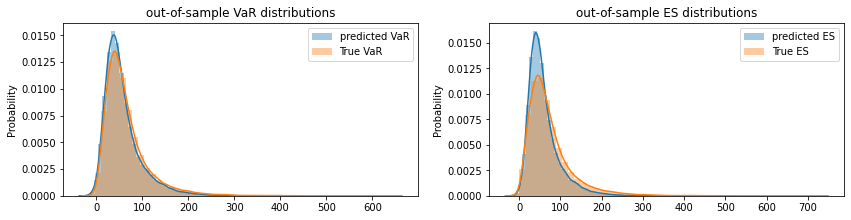

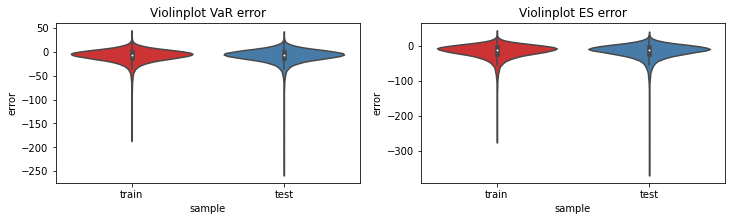

In [22]:
plot_function(var_es_NN(X_train)[:,0:1], true_VaR_train,
              var_es_NN(X_train)[:,1:2], true_ES_train,
              var_es_NN(X_test)[:,0:1], true_VaR_test,
              var_es_NN(X_test)[:,1:2], true_ES_test)

#5 Two-step approach

## 5.1 Value at Risk

### NN

In [24]:
%%time
var_NN = NN_nlayers(Layers=[dim_X,400,1], activation =F.elu).to(device)

train_var_RUbased_fullbatch(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                            learning_rate = 0.1, epochs = 300, stop_eps = 1e-8, verbose = 100)

===Train VaR process===
[iter 0] err = 899.352
[iter 100] err = 75.243
[iter 200] err = 65.043
[iter 300] err = 71.503
Best error = 62.54574966430664
CPU times: user 1.81 s, sys: 995 ms, total: 2.8 s
Wall time: 2.84 s


NRMSE in-sample VaR:  0.31451794505119324
NRMSE out-sample VaR:  0.3198944926261902
NRMSE in-sample ES:  0.0
NRMSE out-sample ES:  0.0
RMSE in-sample VaR:  14.958428382873535
RMSE out-sample VaR:  15.16738510131836
Quantile loss in-sample:  1.1182106733322144
Quantile loss out-sample:  1.7299259901046753
Quantile proba in-sample:  0.05544
Quantile proba out-sample:  0.08018


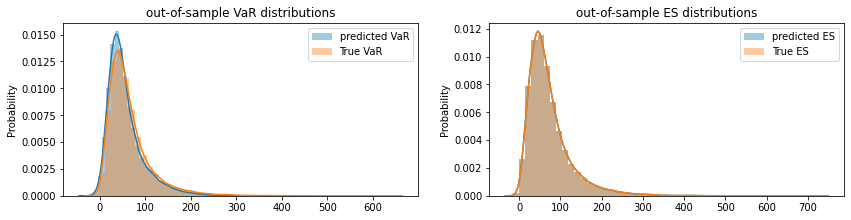

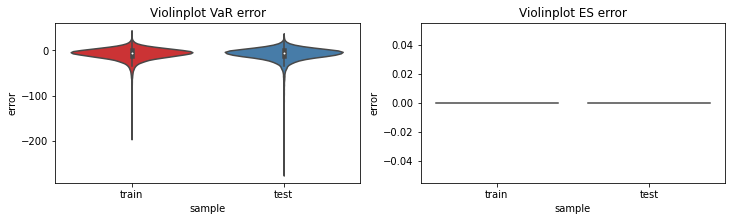

In [25]:
plot_function(var_NN(X_train), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(X_test), true_VaR_test,
              true_ES_test, true_ES_test)

### NN training Huber loss

In [27]:
%%time
var_NN_Huber = NN_nlayers(Layers=[dim_X,400,1], activation =F.elu).to(device)

train_var_huberloss(var_NN_Huber, X_train_var= X_train, y_train= Y_train, eps = eps,
                    learning_rate = 0.1, epochs = 300, stop_eps = 1e-8, verbose = 100)

===Train VaR process===
[iter 0] err = 22.033
[iter 100] err = 1.489
[iter 105] err = nan
Best error = 1.234668254852295
CPU times: user 704 ms, sys: 317 ms, total: 1.02 s
Wall time: 1.03 s


NRMSE in-sample VaR:  0.31451794505119324
NRMSE out-sample VaR:  0.3198944926261902
NRMSE in-sample ES:  0.0
NRMSE out-sample ES:  0.0
RMSE in-sample VaR:  14.958428382873535
RMSE out-sample VaR:  15.16738510131836
Quantile loss in-sample:  1.1182106733322144
Quantile loss out-sample:  1.7299259901046753
Quantile proba in-sample:  0.05544
Quantile proba out-sample:  0.08018


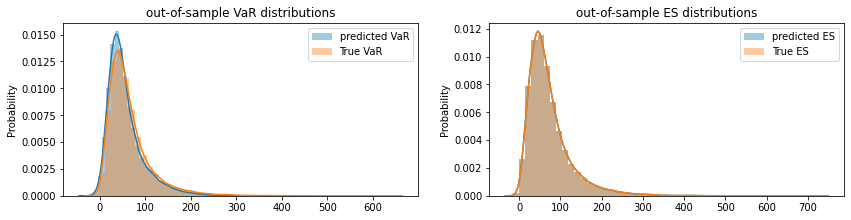

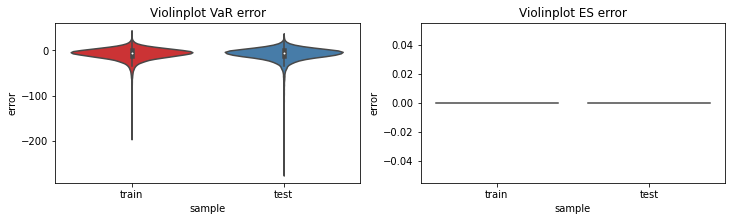

In [28]:
plot_function(var_NN(X_train), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(X_test), true_VaR_test,
              true_ES_test, true_ES_test)

## 5.2 Expected shortfall
To train ES by two-step approach, we take VaR predicted by NN training Huber loss as reference.

In [30]:
Y_train_es = 1/eps*torch.relu(Y_train - var_NN_Huber(X_train).data) + var_NN_Huber(X_train).data

### NN

In [33]:
%%time
es_NN =NN_nlayers(Layers=[dim_X,200,1], activation =F.elu).to(device)

train_l2(es_NN, X_train, Y_train_es, learning_rate=0.01, regularization_weight=0.5,
         epochs = 300, verbose = 100)

[iter 0] err = 15637.352
[iter 100] err = 8548.437
[iter 200] err = 8353.567
[iter 300] err = 8179.725
Best error = 8181.3544921875
CPU times: user 1.26 s, sys: 569 ms, total: 1.83 s
Wall time: 1.85 s


NRMSE in-sample VaR:  0.0
NRMSE out-sample VaR:  0.0
NRMSE in-sample ES:  0.3602451980113983
NRMSE out-sample ES:  0.36500588059425354
RMSE in-sample VaR:  0.0
RMSE out-sample VaR:  0.0
Quantile loss in-sample:  1.3268187046051025
Quantile loss out-sample:  1.3274359703063965
Quantile proba in-sample:  0.02382
Quantile proba out-sample:  0.02466


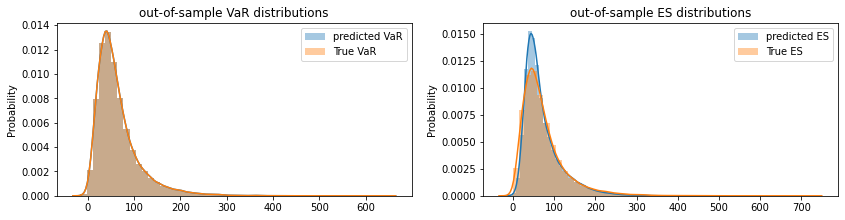

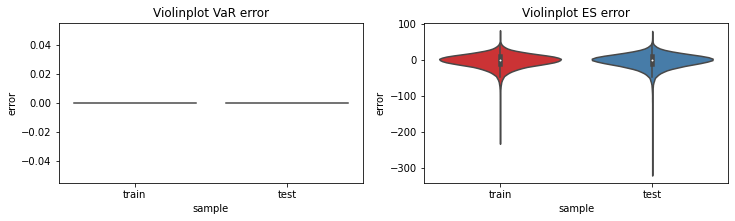

In [34]:
plot_function(true_VaR_train, true_VaR_train,
              es_NN(X_train), true_ES_train,
              true_VaR_test, true_VaR_test,
              es_NN(X_test), true_ES_test)

In [35]:
%%time
es_NN =NN_nlayers(Layers=[dim_X,400,1], activation =F.elu).to(device)

train_l2(es_NN, X_train, Y_train_es, learning_rate=0.1, regularization_weight=0.5,
         epochs = 300, verbose = 100)

[iter 0] err = 15654.835
[iter 100] err = 8057.79
[iter 200] err = 7792.971
[iter 300] err = 7684.746
Best error = 7593.5634765625
CPU times: user 1.81 s, sys: 1.02 s, total: 2.82 s
Wall time: 2.85 s


NRMSE in-sample VaR:  0.0
NRMSE out-sample VaR:  0.0
NRMSE in-sample ES:  0.3668965697288513
NRMSE out-sample ES:  0.36828121542930603
RMSE in-sample VaR:  0.0
RMSE out-sample VaR:  0.0
Quantile loss in-sample:  1.3268187046051025
Quantile loss out-sample:  1.3274359703063965
Quantile proba in-sample:  0.02382
Quantile proba out-sample:  0.02466


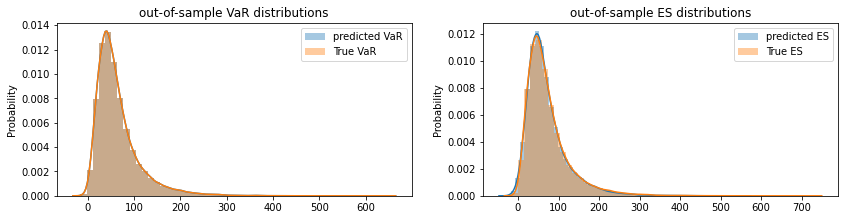

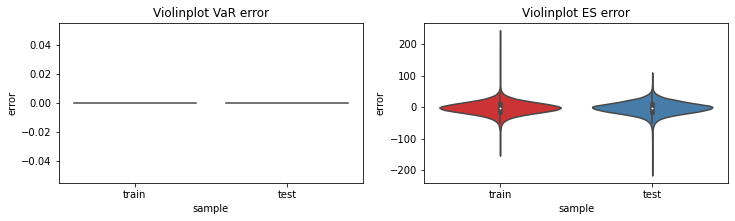

In [36]:
plot_function(true_VaR_train, true_VaR_train,
              es_NN(X_train), true_ES_train,
              true_VaR_test, true_VaR_test,
              es_NN(X_test), true_ES_test)

### ELM

In [38]:
%%time
K= 3000
LR_solution = LR_readout_cuml(regularization_weight= 0.1)

RP_layer = Randomprojection(Layers=[dim_X,K], random_state= None, activation= F.elu,
                            projection='Gauss'
                            )
# ['Gauss', 'Rademacher', 'Achlioptas']
X_train_transfomed = RP_layer.fit_transform(X_train)
X_test_transfomed = RP_layer.fit_transform(X_test)

LR_solution.fit(X_train_transfomed, Y_train_es)

CPU times: user 729 ms, sys: 500 ms, total: 1.23 s
Wall time: 1.23 s


NRMSE in-sample VaR:  0.0
NRMSE out-sample VaR:  0.0
NRMSE in-sample ES:  0.5408863425254822
NRMSE out-sample ES:  0.558231770992279
RMSE in-sample VaR:  0.0
RMSE out-sample VaR:  0.0
Quantile loss in-sample:  1.3268187046051025
Quantile loss out-sample:  1.3274359703063965
Quantile proba in-sample:  0.02382
Quantile proba out-sample:  0.02466


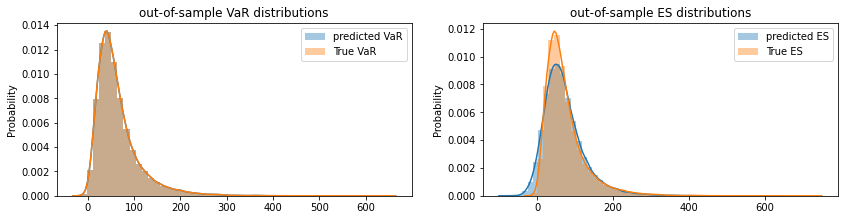

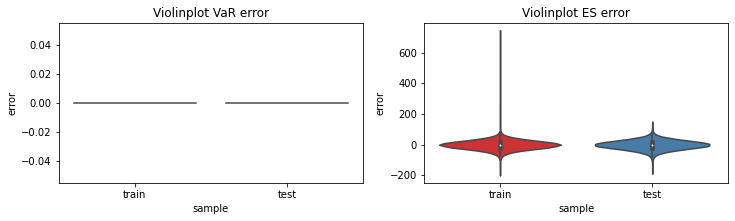

In [39]:
plot_function(true_VaR_train, true_VaR_train,
              LR_solution.predict(X_train_transfomed).view(-1,1), true_ES_train,
              true_VaR_test, true_VaR_test,
              LR_solution.predict(X_test_transfomed).view(-1,1), true_ES_test)

In [ ]:
%%time
K= 4000
LR_solution = LR_readout_cuml(regularization_weight= 0.1)

RP_layer = Randomprojection(Layers=[dim_X,K], random_state= None, activation= F.elu,
                            projection='Achlioptas'
                            )
# ['Gauss', 'Rademacher', 'Achlioptas']
X_train_transfomed = RP_layer.fit_transform(X_train)
X_test_transfomed = RP_layer.fit_transform(X_test)

LR_solution.fit(X_train_transfomed, Y_train_es)

CPU times: user 665 ms, sys: 409 ms, total: 1.07 s
Wall time: 1.07 s


NRMSE in-sample VaR:  0.0
NRMSE out-sample VaR:  0.0
NRMSE in-sample ES:  0.6144218444824219
NRMSE out-sample ES:  0.647994339466095
RMSE in-sample VaR:  0.0
RMSE out-sample VaR:  0.0
Quantile loss in-sample:  1.198670744895935
Quantile loss out-sample:  1.1945217847824097
Quantile proba in-sample:  0.02446
Quantile proba out-sample:  0.02404


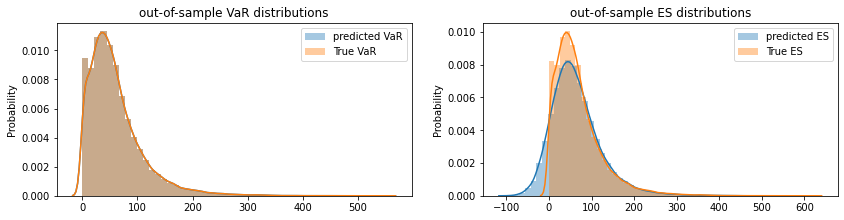

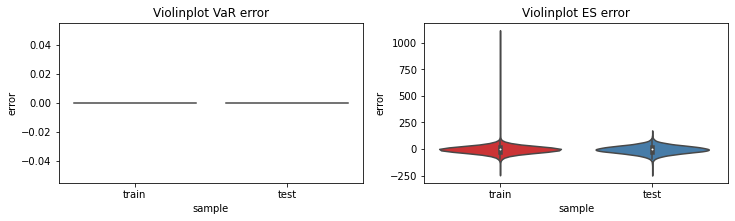

In [ ]:
plot_function(true_VaR_train, true_VaR_train,
              LR_solution.predict(X_train_transfomed).view(-1,1), true_ES_train,
              true_VaR_test, true_VaR_test,
              LR_solution.predict(X_test_transfomed).view(-1,1), true_ES_test)

## 5.3 ELM for ES taking trained weights from VaR NN

In [40]:
%%time
# Using first non-activated layer of var_NN 
X_train_transfomed = F.elu(var_NN.hidden[0](X_train)).detach()
X_test_transfomed = F.elu(var_NN.hidden[0](X_test)).detach()

LR_solution.fit(X_train_transfomed, Y_train_es)

CPU times: user 34.4 ms, sys: 28.8 ms, total: 63.2 ms
Wall time: 64 ms


NRMSE in-sample VaR:  0.0
NRMSE out-sample VaR:  0.0
NRMSE in-sample ES:  0.34471186995506287
NRMSE out-sample ES:  0.34719908237457275
RMSE in-sample VaR:  0.0
RMSE out-sample VaR:  0.0
Quantile loss in-sample:  1.3268187046051025
Quantile loss out-sample:  1.3274359703063965
Quantile proba in-sample:  0.02382
Quantile proba out-sample:  0.02466


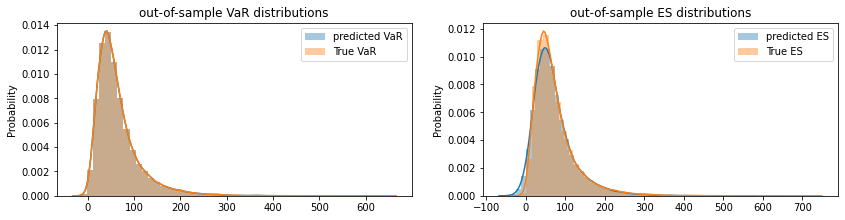

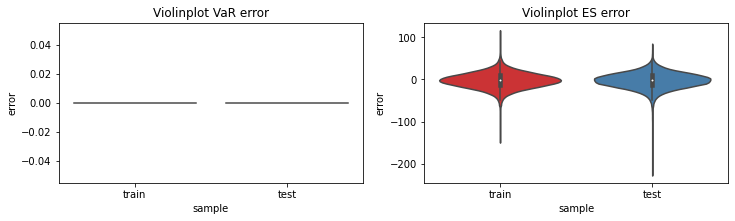

In [41]:
plot_function(true_VaR_train, true_VaR_train,
              LR_solution.predict(X_train_transfomed).view(-1,1), true_ES_train,
              true_VaR_test, true_VaR_test,
              LR_solution.predict(X_test_transfomed).view(-1,1), true_ES_test)

**Super fast and highly accurate** and no need to use too many hidden units.

Hence, the champion would be Two-step approach: Learning VaR via Huber loss by standard network and then taking the trained hidden units of this network to learn ES by linear regression (matrix inversion).
